In [6]:
!pip install findspark


Defaulting to user installation because normal site-packages is not writeable


In [7]:
import findspark
findspark.init()


In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MySparkApp").getOrCreate()


24/02/18 23:06:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [9]:
data_path = "nonull.csv"
df= spark.read.csv(data_path, header=True, inferSchema=True)



In [5]:
df.show()

+-------------------+-------------------+-------------------+-------------------+-------+------+-----------+-----------+---------------+-------------------+
|         event_time|           order_id|         product_id|        category_id|  brand| price|      cat_1|      cat_2|          cat_3|            user_id|
+-------------------+-------------------+-------------------+-------------------+-------+------+-----------+-----------+---------------+-------------------+
|2020-04-29 20:11:49|2298069964415828136|1515966223509122874|2268105407933187062|     hp|152.52|  computers|peripherals|        printer|1515915625509647001|
|2020-04-29 23:42:11|2298175846491357353|1515966223509122666|2268105430162997728|samsung|  8.08|electronics|      audio|      headphone|1515915625511889093|
|2020-04-30 18:01:51|2298729326712980173|1515966223509089265|2360741866917331945|   beko|231.46| appliances|environment|air_conditioner|1515915625510823948|
|2020-04-30 19:27:36|2298772487720140990|15159662235093354

In [6]:
# from pyspark.sql.functions import col, to_date

# # Create new column Date from event_time column
# df_date = df.withColumn("Date", to_date(col("event_time")))

# df_date.show()




In [7]:
# output_path = "WithDate"
# df_date.coalesce(1).write.csv(output_path, header=True)


In [10]:
from pyspark.sql.functions import col, max as max_, countDistinct, sum as sum_, datediff, lit

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Scores_Calculation") \
    .getOrCreate()


# Step 1: Calculate recency, frequency, and monetary values

# Calculate recency (number of days since the last order)
max_order_date = df.groupBy("user_id").agg(max_("event_time").alias("last_order_time"))
current_time = df.select(max_("event_time")).head()[0]
df_recency = max_order_date.withColumn("recency", datediff(lit(current_time), col("last_order_time")))

# Calculate frequency (number of orders per user)
df_frequency = df.groupBy("user_id").agg(countDistinct("order_id").alias("frequency"))

# Calculate monetary value (total spending per user)
df_monetary = df.groupBy("user_id").agg(sum_("price").alias("monetary"))

# Step 2: Define the time frame for recency calculation (e.g., 90 days)

# Step 3: Aggregate the data to calculate RFM scores
rfm_data = df_recency.join(df_frequency, "user_id").join(df_monetary, "user_id")

# Show the RFM data
rfm_data.show()




24/02/18 23:08:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+-------------------+-------+---------+------------------+
|            user_id|    last_order_time|recency|frequency|          monetary|
+-------------------+-------------------+-------+---------+------------------+
|1515915625440051468|2020-10-10 16:27:29|     42|       19|           1619.51|
|1515915625440121544|2020-10-04 12:18:21|     48|        7|            878.32|
|1515915625440937295|2020-11-19 15:36:46|      2|       18|1493.3400000000001|
|1515915625440937382|2020-10-25 17:36:25|     27|       10| 757.6599999999999|
|1515915625440937580|2020-10-10 10:52:42|     42|        8|            275.05|
|1515915625440940742|2020-09-16 13:59:35|     66|        2|59.910000000000004|
|1515915625440940932|2020-09-01 13:45:29|     81|        6|1854.2500000000002|
|1515915625440941441|2020-01-16 12:06:23|    310|        1|             80.76|
|1515915625440943934|2020-10-11 17:17:47|     41|       24| 5877.459999999999|
|1515915625440945265|2020-11-18 19:45:39|      3|   

In [11]:
rfm_data.count()

218524

In [12]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("RFM_Normalization") \
    .getOrCreate()

# Convert the RFM scores to a dense vector
rfm_vector = rfm_data.rdd.map(lambda x: (x["user_id"], Vectors.dense([x["recency"], x["frequency"], x["monetary"]]))).toDF(["user_id", "features"])

# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Fit and transform the data
scaler_model = scaler.fit(rfm_vector)
normalized_rfm = scaler_model.transform(rfm_vector)

# Show the normalized RFM data
normalized_rfm.show()



24/02/18 23:15:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+-------------------+--------------------+--------------------+
|            user_id|            features|     scaled_features|
+-------------------+--------------------+--------------------+
|1515915625440051468| [42.0,19.0,1619.51]|[0.13084112149532...|
|1515915625440121544|   [48.0,7.0,878.32]|[0.14953271028037...|
|1515915625440937295|[2.0,18.0,1493.34...|[0.00623052959501...|
|1515915625440937382|[27.0,10.0,757.65...|[0.08411214953271...|
|1515915625440937580|   [42.0,8.0,275.05]|[0.13084112149532...|
|1515915625440940742|[66.0,2.0,59.9100...|[0.20560747663551...|
|1515915625440940932|[81.0,6.0,1854.25...|[0.25233644859813...|
|1515915625440941441|   [310.0,1.0,80.76]|[0.96573208722741...|
|1515915625440943934|[41.0,24.0,5877.4...|[0.12772585669781...|
|1515915625440945265|[3.0,19.0,5456.57...|[0.00934579439252...|
|1515915625440946733| [33.0,26.0,2698.23]|[0.10280373831775...|
|1515915625440947224|[59.0,7.0,198.679...|[0.18380062305295...|
|1515915625440947741| [7.0,50.0,10036.37

In [ ]:
import matplotlib.pyplot as plt

# Collect scaled features to the driver node
scaled_features = normalized_rfm.select("scaled_features").rdd.map(lambda x: x.scaled_features.toArray()).collect()

# Plot the scaled features
plt.figure(figsize=(8, 6))
for feature in scaled_features:
    plt.plot(feature)
plt.title("Scaled Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.grid(True)
plt.show()


/tmp/ipykernel_42775/2455338906.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


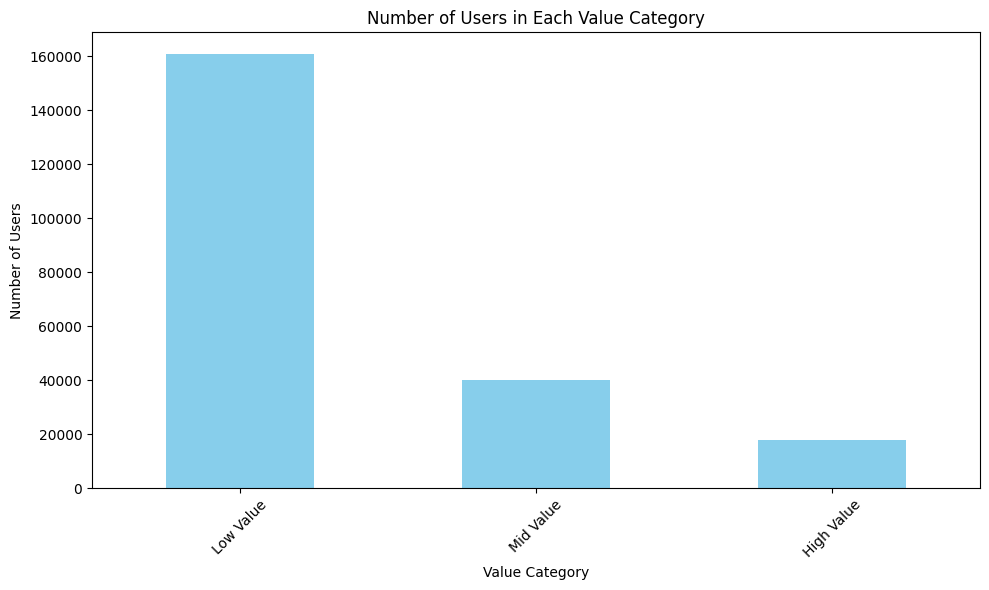

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the PySpark DataFrame to a Pandas DataFrame
rfm_scores_pd = rfm_scores.toPandas()

# Count the number of users in each segment
segment_counts = rfm_scores_pd["segment"].value_counts()

# Plot the graph
plt.figure(figsize=(10, 6))
segment_counts.plot(kind="bar", color="skyblue")
plt.title("Number of Users in Each Value Category")
plt.xlabel("Value Category")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month


# Extract month component from event_time column
df_mon = df.withColumn("month_key", month(col("event_time")))

# Show the DataFrame with new column month_key
df_mon.select("event_time", "month_key").show()



+-------------------+---------+
|         event_time|month_key|
+-------------------+---------+
|2020-04-29 20:11:49|        4|
|2020-04-29 23:42:11|        4|
|2020-04-30 18:01:51|        4|
|2020-04-30 19:27:36|        4|
|2020-04-30 21:37:48|        4|
|2020-05-01 12:54:33|        5|
|2020-05-01 22:40:42|        5|
|2020-05-02 23:25:58|        5|
|2020-05-04 07:07:11|        5|
|2020-05-06 08:37:23|        5|
|2020-05-06 11:40:59|        5|
|2020-05-06 18:58:35|        5|
|2020-05-07 17:06:03|        5|
|2020-05-07 17:42:39|        5|
|2020-05-08 00:34:21|        5|
|2020-05-09 06:14:01|        5|
|2020-05-10 14:59:23|        5|
|2020-05-10 19:13:40|        5|
|2020-05-11 08:18:33|        5|
|2020-05-11 10:41:08|        5|
+-------------------+---------+
only showing top 20 rows



In [11]:
df_mon.show()

+-------------------+-------------------+-------------------+-------------------+-------+------+-------------------+-----------+-----------+---------------+---------+
|         event_time|           order_id|         product_id|        category_id|  brand| price|            user_id|      cat_1|      cat_2|          cat_3|month_key|
+-------------------+-------------------+-------------------+-------------------+-------+------+-------------------+-----------+-----------+---------------+---------+
|2020-04-29 20:11:49|2298069964415828136|1515966223509122874|2268105407933187062|     hp|152.52|1515915625443027224|  computers|peripherals|        printer|        4|
|2020-04-29 23:42:11|2298175846491357353|1515966223509122666|2268105430162997728|samsung|  8.08|1515915625445938216|electronics|      audio|      headphone|        4|
|2020-04-30 18:01:51|2298729326712980173|1515966223509089265|2360741866917331945|   beko|231.46|1515915625446617606| appliances|environment|air_conditioner|        4

# Calculate Purchase(sum of price) by users per year-month

In [19]:
from pyspark.sql.functions import col, sum, to_date

user_purchase_month = df_mon.withColumn("purchase_month", to_date(col("event_time")).substr(1, 7)).groupBy("month_key").agg(sum("price").alias("Monthly purchase by user")).orderBy("month_key")

user_purchase_month.show()




+---------+------------------------+
|month_key|Monthly purchase by user|
+---------+------------------------+
|        1|       1726269.314012686|
|        2|        2212593.63003171|
|        3|      2836594.8920063437|
|        4|      1659148.3920063446|
|        5|       7638151.942006315|
|        6|       7479405.318025369|
|        7|    1.6006443429999901E7|
|        8|     2.730199569200609E7|
|        9|    1.6757457076018898E7|
|       10|     1.936188824805694E7|
|       11|    1.1767545436018975E7|
+---------+------------------------+



In [14]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 2.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 KB 2.4 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 2.6 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.1 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.2 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 1.9 MB/s eta 0:00:000:00:01m eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


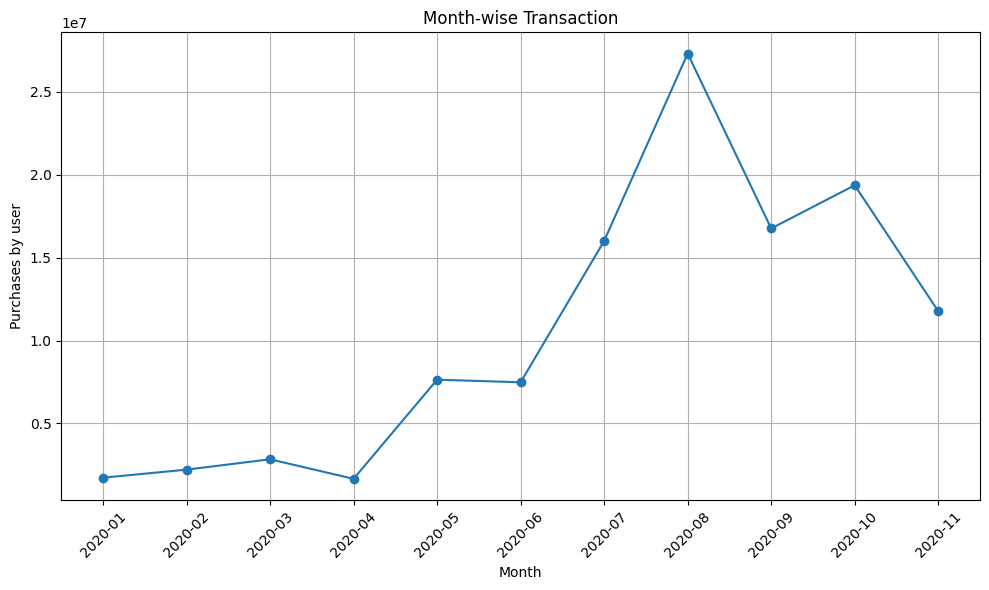

None

In [18]:
from pyspark.sql.functions import col, sum, to_date
import matplotlib.pyplot as plt

# Calculate GMV (sum of price) per year-month
user_purchase_month_GMV = df_mon.withColumn("purchase_month", to_date(col("event_time")).substr(1, 7)) \
    .groupBy("purchase_month") \
    .agg(sum("price").alias("Purchase by user")) \
    .orderBy("purchase_month")

# Convert PySpark DataFrame to Pandas DataFrame for plotting
user_purchase_month_GMV_pd = user_purchase_month_GMV.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(user_purchase_month_GMV_pd["purchase_month"], user_purchase_month_GMV_pd["GMV"], marker='o', linestyle='-')
plt.title("Month-wise Transaction")
plt.xlabel("Month")
plt.ylabel("Purchases by user")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

display(plt.show())
